In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

In [4]:
import numpy as np

###
библиотеки

In [2]:
df = pd.read_excel('2020_clean.xlsx', parse_date=True)
df = df.set_index('Date')
df.index = df.asfreq('D').index

###
Читаем файл, столбец с Датой парситься как Datetime, после чего он устанавливается как Index с frequency (частотность) по дням

In [5]:
df = df.replace(0, np.NaN)

In [7]:
df = df.fillna(df.bfill())

## ВАЖНОЕ ОТЛИЧИЕ!
Нули заменяю на NaN (местный NULL) значения

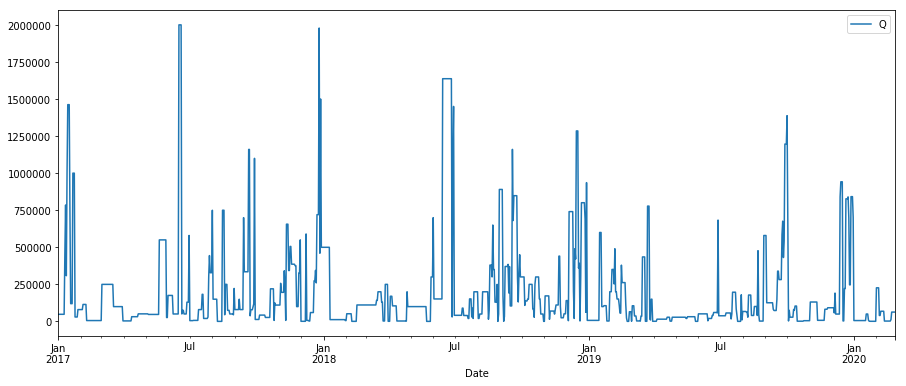

In [26]:
df.plot(figsize=(15,6))

###
Смотрим что имеем, а имеем мы данные по 3-ем годам (+небольшой кусочек 2020)

In [27]:
decomp = decompose(df, period=365)

#### Строим декомпозицию, период = 365 потому что:
"with daily observations and large annual cycles, period=365"

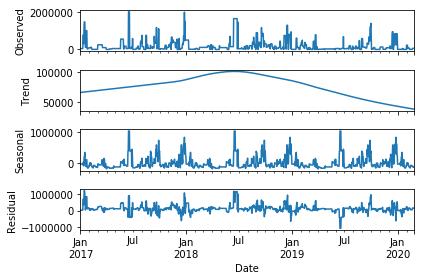

In [28]:
decomp.plot();

###
Как сделать этот график больше размером для наглядности я не знаю (могу узнать, но мне кажется это нецелесообразным). В принципе все правильно - проглядывается сезонность, тренд пошёл вниз, средний сезонный цикл тоже ±

In [29]:
short_df = df.head(800)
short_decomp = decompose(short_df, period=365)

In [30]:
fcast = forecast(short_decomp, steps=600, fc_func=seasonal_naive, seasonal=True)

###
Тут по срезу данных (всего 1153 записи, здесь используется 800) строится предсказание на 600 следующих дней, использую функцию seasonal_naive (а не drift как в примере)

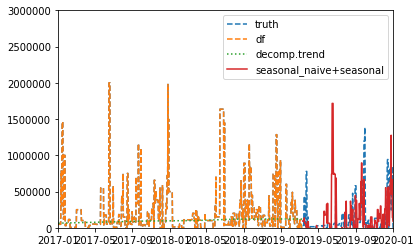

In [31]:
plt.plot(df, '--', label='truth')
plt.plot(short_df, '--', label='df')
plt.plot(short_decomp.trend, ':', label='decomp.trend')
plt.plot(fcast, '-', label=fcast.columns[0])

plt.xlim('2017','2020'); plt.ylim(0,3000000);
plt.legend();

In [32]:
#fcast['seasonal_naive+seasonal'].sum()

###
В принципе (судя по графику выше) прогноз "попал" в тендению 2019 года (даже несмотря на то, что он март с июлем поменял местами - данных очень мало всё-таки), выглядит похожим на правду 

In [33]:
decomp = decompose(df, period=365)
fcast = forecast(decomp, steps=365, fc_func=seasonal_naive, seasonal=True)

###
Теперь строим прогноз на следующий год

In [34]:
result = pd.concat([df, fcast])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


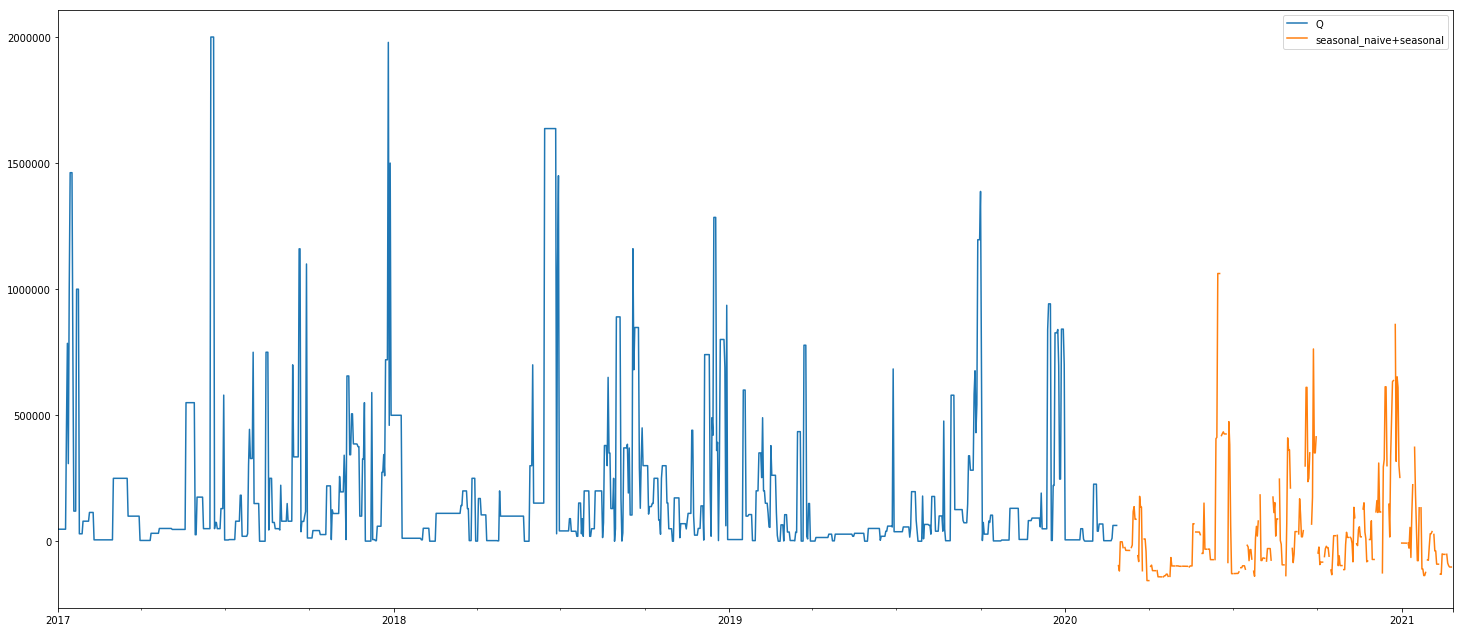

In [35]:
result.plot(figsize=(25,11))

## !!!!
График съехал вниз, но это НЕпринципиально в данном случае (bfill)

In [36]:
fcast['castil'] = fcast['seasonal_naive+seasonal'] - float(fcast.min())

result = pd.concat([df, fcast])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
result['year'] = ''
result['date'] = pd.to_datetime(result.index)

for i in range(len(result['date'])):
    result['year'][i] = result['date'][i].timetuple().tm_year

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


###
Выдираю год из индекса (возможно не самым оптимальным образом)

In [38]:
result.head()

,Q,castil,seasonal_naive+seasonal,year,date
2017-01-01,48200.0,NaN,NaN,2017,2017-01-01
2017-01-02,48200.0,NaN,NaN,2017,2017-01-02
2017-01-03,48200.0,NaN,NaN,2017,2017-01-03
2017-01-04,48200.0,NaN,NaN,2017,2017-01-04
2017-01-05,48200.0,NaN,NaN,2017,2017-01-05


In [39]:
result.groupby('year').sum()[['seasonal_naive+seasonal']]

,seasonal_naive+seasonal
year,
2017,0.000000e+00
2018,0.000000e+00
2019,0.000000e+00
2020,1.389759e+07
2021,-1.125838e+06


In [40]:
result.groupby('year').sum()[['castil']]

,castil
year,
2017,0.000000e+00
2018,0.000000e+00
2019,0.000000e+00
2020,5.499386e+07
2021,6.501878e+06


## В результате костыль дает левые данные, а прогноз.. неоптимистичен, но реален